In [279]:
from scipy.stats import gaussian_kde, beta
from scipy.signal import argrelmax
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tq

plt.style.use('dark_background')

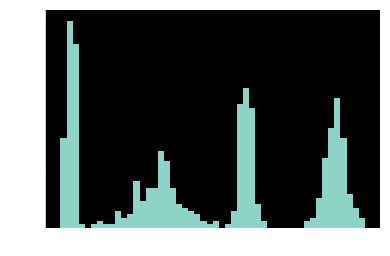

In [2]:
X = np.concatenate([np.random.randn(150)*1.0 + 8,
                    np.random.randn(130)*0.5 - 0,
                    np.random.randn(145)*2.0 - 8,
                    np.random.randn(145)*0.4 - 16])
plt.hist(X, bins=50, density=True);

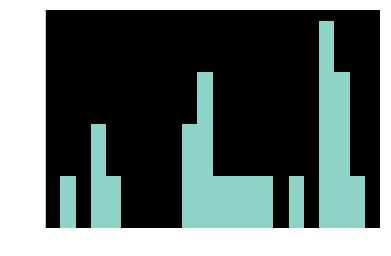

In [189]:
chondrite = np.array([20.77, 22.56, 22.71, 22.99, 26.39, 27.08, 27.32, 27.33, 27.57, 27.81, 28.69, 
                      29.36, 30.25, 31.89, 32.88, 33.23, 33.28, 33.40, 33.52, 33.83, 33.95, 34.82])
plt.hist(chondrite, bins=20, density=True);

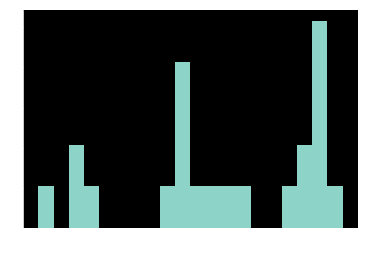

In [157]:
chondrite_scaled = np.array([.04, .15, .16, .18, .40, .44, .45, .46, .47, .49, .54,
                             .59, .64, .75, .81, .83, .84, .84, .85, .87, .87, .92])
plt.hist(chondrite_scaled, bins=20, density=True);

In [36]:
single = np.array([0, 0.1, 0.05])

In [272]:
def gaussian(x, mu=0, sigma=1):
    return ((2*np.pi*sigma**2)**-0.5) * np.exp(-0.5 * ((x - mu)/sigma)**2)

def gaussian_deriv(x, mu=0, sigma=1):
    return -((x-mu)/sigma**2)*gaussian(x, mu, sigma)

def gaussian_deriv_2(x, mu=0, sigma=1):
    return ((x-mu)**2/sigma**2 - 1)*gaussian(x, mu, sigma)/sigma**2

# def gaussian_kde(x, X, sigma):
#     if np.isscalar(x):
#         x = np.array([x])
#     return gaussian(x.repeat(len(X)).reshape(len(x), len(X)), mu=X, sigma=sigma).mean(axis=1)
    
def gaussian_kde_deriv(x, X, sigma):
    if np.isscalar(x):
        x = np.array([x])
    return gaussian_deriv(x.repeat(len(X)).reshape(len(x), len(X)), mu=X, sigma=sigma).mean(axis=1)

def gaussian_kde_deriv_2(x, X, sigma):
    if np.isscalar(x):
        x = np.array([x])
    return gaussian_deriv_2(x.repeat(len(X)).reshape(len(x), len(X)), mu=X, sigma=sigma).mean(axis=1)

def count_kde_modes(K, qk):
    modes = find_all_kde_modes(K, qk)
    return len(modes)

def find_all_kde_modes_old(K, qk):    
    f   = lambda x : -K.pdf(x)
    df  = lambda x : -gaussian_kde_deriv(x,   X=K.dataset.squeeze(), sigma=K.factor * K.dataset.std(ddof=1))
    ddf = lambda x : -gaussian_kde_deriv_2(x, X=K.dataset.squeeze(), sigma=K.factor * K.dataset.std(ddof=1))
    
    Xmin = K.dataset.min()
    Xmax = K.dataset.max()
    Xstd  = K.dataset.std()
    
    return find_all_minima(f=f, df=df, ddf=ddf, low=Xmin - Xstd/4, high=Xmax + Xstd/4, break_after_n=qk)

def find_all_minima_old(f, df, ddf, random_starts=500, low=-100.0, high=100, break_after_n=False):
    minima = np.array([])

    for ix in range(random_starts):
        x0 = np.random.uniform(low=low, high=high)
        results = opt.root(df, x0=x0, jac=ddf)
#         new_minimum = opt.minimize(f, x0=x0, jac=df, hess=ddf, method='Newton-CG', options={'xtol': 1e-3})['x']
        if ddf(results['x']) > 0 and results['success']:
            if np.any(minima):
                if np.any([np.isclose(results['x'], minimum, rtol=1e-2) for minimum in minima]):
                    pass
                else:
                    minima = np.concatenate((minima, results['x']))
            else:
                minima= np.concatenate((minima, results['x']))
                
        if break_after_n:
            if len(minima) > break_after_n:
                break
    minima.sort()
#     minima = minima[ddf(minima) > 1e-12]
#     minima = minima[np.abs(df(minima)) < 1e-6 ]
    return minima

def find_all_kde_modes(K, break_after_n):
    f      = lambda x : K.pdf(x)
    # Grid search
    b_left  = K.dataset.min() - K.dataset.std()/4
    b_right = K.dataset.max() + K.dataset.std()/4
    xx = np.arange(b_left, b_right, 0.001)
    gs_f_max = xx[argrelmax(f(xx))[0]]
    
    return gs_f_max

def find_all_kde_modes_smart(K, break_after_n):
    f      = lambda x : K.pdf(x)
    negf   = lambda x : -f(x)

    df     = lambda x : gaussian_kde_deriv(x, K.dataset[0], K.factor * K.dataset.std(ddof=1))
    negdf  = lambda x : -df(x)

    ddf    = lambda x : gaussian_kde_deriv_2(x, K.dataset[0], K.factor * K.dataset.std(ddof=1))
    negddf = lambda x : -ddf(x)

    #------------------

    b_left  = K.dataset.min() - K.dataset.std()/4
    b_right = K.dataset.max() + K.dataset.std()/4

    x_init  = K.dataset.min()

    ftol=1e-32
    eps=1e-12
    gtol=1e-12

    j_maxs = []
    f_maxs = []
    j_mins = []
    f_mins = []
    
    #--------------------
    
    while not np.isclose(b_left, b_right, 1e-1):
        for fun, jac, mins in zip([negdf, negf, df, f], [negddf, negdf, ddf, df], [j_maxs, f_maxs, j_mins, f_mins]):
            results_lbfgsb_jac = opt.minimize(fun, x0=x_init, bounds=([b_left, b_right],), jac=jac, options={'ftol' : ftol, 'gtol' : gtol}, method='L-BFGS-B')
            results_slsqp_jac  = opt.minimize(fun, x0=x_init, bounds=([b_left, b_right],), jac=jac, options={'ftol' : ftol}, method='SLSQP')

            results_lbfgsb = opt.minimize(fun, x0=x_init, bounds=([b_left, b_right],), options={'ftol' : ftol, 'eps' : eps, 'gtol' : gtol}, method='L-BFGS-B')
            results_slsqp  = opt.minimize(fun, x0=x_init, bounds=([b_left, b_right],), options={'ftol' : ftol, 'eps' : eps}, method='SLSQP')

            results_nm     = opt.minimize(fun, x0=x_init, method='Nelder-Mead', options={'fatol' : 1e-16, 'initial_simplex' : np.array([b_left,x_init]).reshape(-1,1)})
            if results_nm['x'] < x_init:
                results_nm['success'] = False

            fun_min = min([results['x'] for results in [results_lbfgsb_jac, results_slsqp_jac, results_lbfgsb, results_slsqp, results_nm] if results['success']])

            for eta in [0.1, 0.25, 0.5, 0.75, 0.9, 0.925, 0.95, 0.99, 0.999]:
                results_tnc_jac = opt.minimize(fun, x0=x_init, bounds=([b_left, b_right],), jac=jac, options={'ftol' : ftol, 'gtol' : gtol,  'eta' : eta}, method='tnc')
                results_tnc    = opt.minimize(fun, x0=x_init, bounds=([b_left, b_right],), options={'ftol' : ftol, 'gtol' : gtol, 'eps' : eps, 'eta' : eta}, method='tnc')
                try:
                    tnc_min = min([results['x'] for results in [results_tnc_jac, results_tnc] if results['success']])
                except ValueError:
                    pass

            fun_min = min(fun_min, tnc_min)

            b_left = x_init
            x_init = fun_min
            mins.append(fun_min[0])

            while f(x_init) < 1e-6 and x_init < b_right:
                x_init+=1e-3
        
            while np.abs(df(x_init)) < 1e-5 and np.abs(ddf(x_init)) < 1e-2:
                x_init+=1e-3

            if np.isclose(b_left, b_right, 1e-1):
                break
                
    f_maxs = np.array(f_maxs)
    f_maxs = f_maxs[ddf(f_maxs) < 0]
    return np.array(f_maxs)

def binary_search(K, qk, tol, min_sigma, max_sigma):
    while not np.isclose(max_sigma - min_sigma, tol):
        sigma = np.round(10**(0.5*(np.log10(min_sigma) + np.log10(max_sigma))), int(-np.log10(tol)))
        K.set_bandwidth(sigma/K.dataset.std(ddof=1))
        num_modes = count_kde_modes(K, qk);
        if num_modes > qk:
            min_sigma = sigma
        elif num_modes <= qk:
            max_sigma = sigma
    return max_sigma
    
def find_critical_bandwidth(K, qk=1, tol=1e-16, min_sigma = 1e-3, max_sigma = 1e2):
    return binary_search(K, qk, tol= tol, min_sigma= min_sigma, max_sigma= max_sigma)

def bootstrap_sample(X, sigma, sample_size):
    return (1 + sigma ** 2 / X.var(ddof=1))**-0.5 * (np.random.choice(X, size=sample_size, replace=True) + np.random.randn(sample_size)*sigma)
    

def silvermans_test(X, qk=1, num_bootstraps = 200, tol=1e-3, use_beta=True):
    # Create Gaussian KDE object
    K = gaussian_kde(X)
    
    # find critical bandwidth
    sigma_critical = find_critical_bandwidth(K, qk=qk, tol=tol)
    
    # Set KDE kernel bandwidth to critical
    K.set_bandwidth(sigma_critical/K.dataset.std(ddof=1))
    
    # Check and redo if necessary
    while count_kde_modes(K, qk) > qk:
        
        sigma_critical = find_critical_bandwidth(K, qk=qk, tol=tol)
        K.set_bandwidth(sigma_critical / K.dataset.std(ddof=1))
    
    # Estimate p-value
    p = 0
    
    if use_beta:
        a = 1
        b = 1
        from scipy.stats import beta
        while (beta.cdf(0.9, a, b) > 0.005) and (beta.cdf(0.9, a, b) < 0.995):
            Z = bootstrap_sample(X, sigma=sigma_critical, sample_size=len(X))
            Kz = gaussian_kde(Z)
            Kz.set_bandwidth(sigma_critical/Kz.dataset.std(ddof=1))
            num_modes = count_kde_modes(Kz, qk)
            if qk >= num_modes:
                a += 1
            else:
                b += 1
            print (a - 1.)/(a + b - 2.), beta.cdf(0.9, a, b)
        return (a - 1.)/(a + b - 2.)
    else:
        for ix in tq.tqdm(range(num_bootstraps)):
            # Sample from KDE with critical bandwidth
            Z = bootstrap_sample(X, sigma=sigma_critical, sample_size=len(X))

            # Create KDE object for new sample
            Kz = gaussian_kde(Z)
            Kz.set_bandwidth(sigma_critical/Kz.dataset.std(ddof=1))

            num_modes = count_kde_modes(Kz, qk)
            p+= float(qk>=num_modes)/num_bootstraps
        return p

def plot_kde(K):
    Xmin = K.dataset.min()
    Xmax = K.dataset.max()
    Xstd  = K.dataset.std(ddof=1)
    x = np.linspace(Xmin-Xstd/4, Xmax+Xstd/4, 1000)
    plt.plot(x, K.pdf(x))
    
def plot_modes(K, modes):
    plt.plot(modes, K.pdf(modes), 'o', ms=10)

In [262]:
data = chondrite

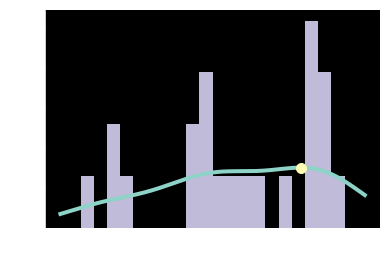

In [263]:
qk = 1

K = gaussian_kde(data)
sigma_critical = find_critical_bandwidth(K, qk=qk, tol=1e-3)
K.set_bandwidth(sigma_critical/ K.dataset.std(ddof=1))
plot_kde(K)
modes = find_all_kde_modes(K, qk)
plot_modes(K, modes)
plt.hist(data, density=True, bins=20);

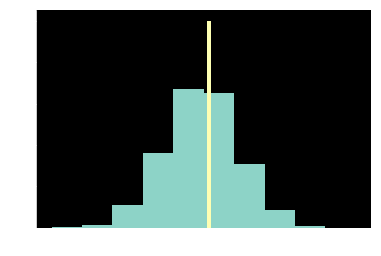

In [264]:
zstd = []
for ix in range(10000):
    Z = bootstrap_sample(data, sigma_critical, len(data))
    zstd.append(Z.std(ddof=0))
    
plt.hist(zstd, density=True)
plt.vlines(data.std(ddof=0), 0, 1.0, color='C1')

100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


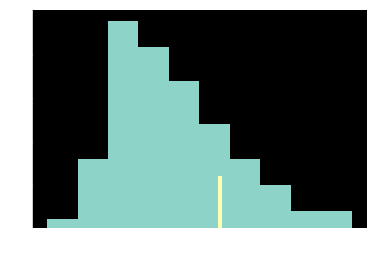

In [265]:
bs_sigma_critical = []
for ix in tq.tqdm(range(100)):
    Z = bootstrap_sample(data, sigma_critical, len(data))
    Kz = gaussian_kde(Z)
    bs_sigma_critical.append(find_critical_bandwidth(Kz, qk=qk, tol=1e-3))
    
plt.hist(bs_sigma_critical)
plt.vlines(sigma_critical, 0, 6, color='C1')

In [297]:
silvermans_test(data, qk=2, num_bootstraps=100, use_beta=False, tol=1e-3)

100%|██████████| 100/100 [00:00<00:00, 115.77it/s]


0.9400000000000006

In [274]:
find_critical_bandwidth(K, 4, tol=1e-3)

0.481

In [43]:
from scipy.stats import beta

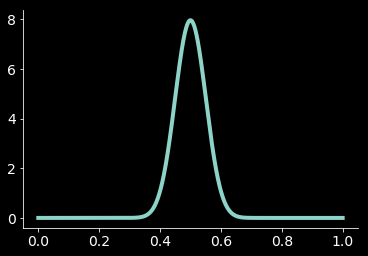

In [293]:
CI = 0.01
a = 120
b = 500
MAP = (a - 1.) / (a + b - 2.)

x = np.linspace(0, 1, 1000)
pbeta = beta.pdf(x, 50, 50)
plt.plot(x, pbeta)

In [294]:
beta.interval(0.95, a, b)

(0.1634324276080675, 0.2255366164249928)